In [1]:
from pylab import *
from scipy.spatial import distance
from scipy.ndimage import interpolation
import tables
import random as pyrandom

In [2]:
def showgrid(images,rows=None,cols=10,size=1,cmap=cm.gray):
    if rows is None: rows = (len(images)+cols-1)//cols
    figsize(cols*size,rows*size)
    for i in range(len(images)):
        subplot(rows,cols,i+1)
        imshow(images[i],cmap=cmap)

In [3]:
with tables.openFile("mnist.h5","r") as mnist:
    print mnist
    images = array(mnist.root.deskewed,'f')
    labels = array(mnist.root.labels,'i')
    test_images = array(mnist.root.test_deskewed,'f')
    test_labels = array(mnist.root.test_labels,'i')

mnist.h5 (File) ''
Last modif.: 'Sun Jun 17 16:43:50 2012'
Object Tree: 
/ (RootGroup) ''
/deskewed (EArray(60000, 28, 28), shuffle, zlib(9)) ''
/images (CArray(60000, 28, 28), shuffle, zlib(9)) ''
/labels (CArray(60000,), shuffle, zlib(9)) ''
/test_deskewed (EArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_images (CArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_labels (CArray(10000,), shuffle, zlib(9)) ''


Principal Component Analysis
============================

Recall that classifiers are functions $D(x)$ from feature vectors $x$ to classes $c$,
where $D(x)$ is determined by a training set $T = \\{(x_1,c_1),...,(x_N,c_N)\\}$.

We have already considered a number of transformations of the input vectors: feature extraction,
canonicalization, kernels, etc.  These are functions $f:x\rightarrow\xi$ that transform the input
feature vectors into some other space in which recognition is easier.

There are also automatic ways of constructing such transformations.
One of the most important ones is _principal component analysis_ (PCA).
PCA is a linear transformation of the input space that results in the best
possible approximation to the input vectors with a given number of dimensions.

That is, 

- $f(x) = Mx+\mu$
- $||f(x)-f(y)|| \approx ||x-y||$ for $x,y \in T$.
- $f(x)\in R^m$ and $x\in R^n$ where $m \lt n$

Note that we are not using the class labels in the construction.


The construction of $f$ starts by computing the mean of the vectors in the training set
and subtracting it from the original data:

$\hat{\mu} = \frac{1}{N} \sum_{i=1}^N x_i$

(We use $\hat{\cdot}$ to indicate quantities that are estimated.)

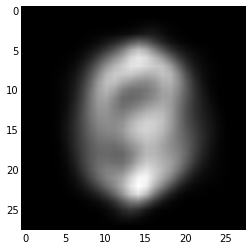

In [4]:
mu = mean(images,axis=0)
gray()
imshow(mu)

Now we subtract the mean from all the data vectors.
This actually doesn't change the input too much.

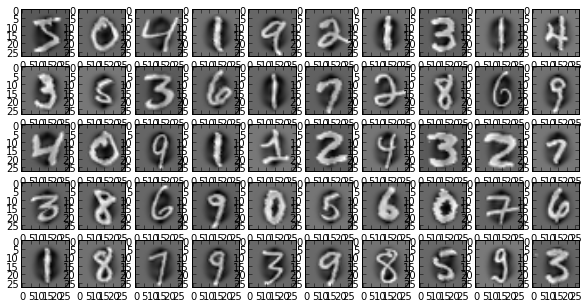

In [5]:
centered = images - mu[newaxis,:,:]
showgrid(centered[:50])

In [6]:
def make2d(a): return a.reshape(len(a),prod(a.shape[1:]))

Next, we compute the covariance matrix (we already have seen that when looking at Gaussian densities).

In [7]:
cov = dot(make2d(centered).T,make2d(centered))/len(centered)
print cov.shape,amin(cov),amax(cov)

(784, 784) -0.114308 0.20846

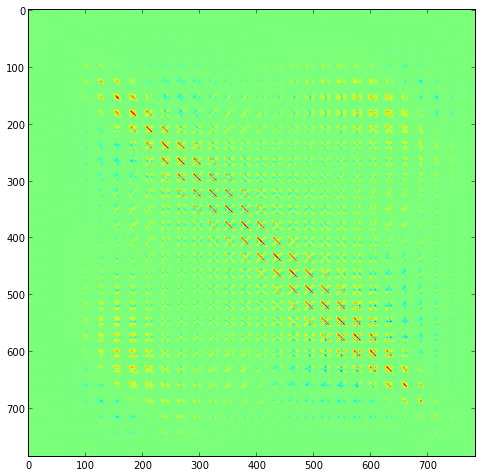

In [19]:
figsize(8,8)
imshow(cov,cmap=cm.jet,vmin=-0.2,vmax=0.2)

The matrix $M$ of the PCA transformation is now given by the eigenvectors
of the covariance matrix.
The top $m$ eigenvectors give us a projection matrix from $n$ to $m$ dimensions
that represents the best linear approximation to the input vectors.
(Here "top" refers to the eigenvectors in descending order of magnitude of
their corresponding eigenvectors.)

In [9]:
evals,evecs = linalg.eig(cov)
top = argsort(-evals)
evals = evals[top]
evecs = evecs.T[top] # NB: eigenvectors come out backwards
print evals.shape,evecs.shape

(784,) (784, 784)

We can look at these eigenvectors as images and see that they represent
meaningful variations of the input in some way;
the first eigenvector, for example, reprents the variation along
the skinny/rounded character axis.

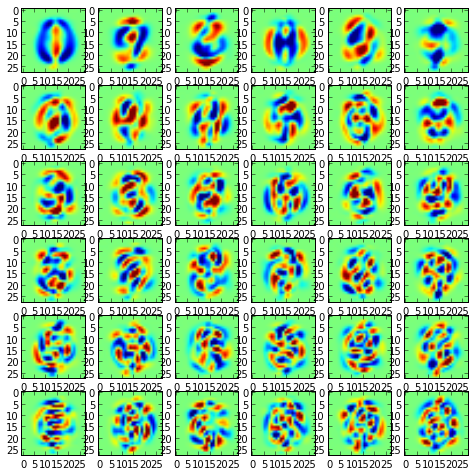

In [20]:
figsize(8,8)
for i in range(36):
    subplot(6,6,i+1)
    imshow(real(evecs[i]).reshape(28,28),vmin=-0.1,vmax=+0.1,cmap=cm.jet)

In [11]:
evecs.shape

(784, 784)

To take a data set and transform mit, we now construct a `project` function.
It first subtracts the mean and then projects using the $M$ matrix we 
constructed above.

In [12]:
def project(data,k=50):
    centered = data-mu.ravel()[newaxis,:]
    return dot(evecs[:k],data.T).T
    

When we project the input vectors into this new space,
the vectors don't look all that meaningful
However, we can see that the most variation exists in the first
few components.

(60000, 50)

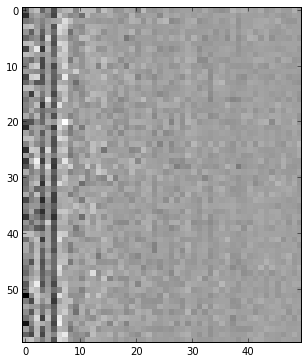

In [13]:
projected = project(make2d(images))
print projected.shape
figsize(6,6)
imshow(projected[:60],interpolation='nearest')

We can also reconstruct the high dimensionsal (original) representation
by reversing this process.

In [14]:
def reconstruct(projected):
    return dot(projected,evecs[:projected.shape[1]])
reconstructed = reconstruct(projected)
print reconstructed.shape

(60000, 784)

Note that the reconstructed images are not exactly like the original images;
some detail has been distorted, more for some characters than for others.

Because it allows us to represent large numbers of data components with fewer ones,
PCA is commonly used in data compression.
Implicitly, it forms an important part of JPEG and MPEG image and video compression.

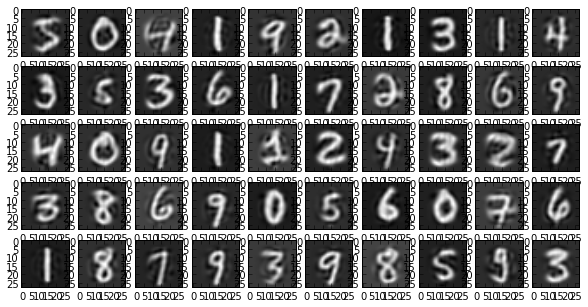

In [21]:
figsize(8,8)
showgrid(reconstructed[:50].reshape(50,28,28))

PCA as Preprocessing for Classifiers
====================================

We started out motivating the use of PCA as preprocessing for pattern recognition.
Let's try this out.

For this to work, we need to transform both the training and the test set vectors.
The labels, of course, stay the same.

Here, we use nearest neighbor classification, but PCA can be used as a preprocessing
step to many kinds of pattern recognition algorithms.

In [16]:
test_projected = project(make2d(test_images))
print test_projected.shape

(10000, 50)

In [17]:
def nneval(training,ltraining,testing,ltesting,metric='euclidean',p=2):
    ds = distance.cdist(make2d(testing),make2d(training),metric=metric,p=p)
    closest = argmin(ds,axis=1)
    predictions = [ltraining[i] for i in closest]
    errors = sum(array(predictions)!=array(ltesting))
    return errors*1.0/len(testing)

In [18]:
nneval(projected[:1000],labels[:1000],test_projected,test_labels)

0.071199999999999999

There are some conditions where PCA doesn't work well.
For example, if we know that the information about class labels is primarily contained
in just a few input dimensions, PCA tends to mix this information up with other,
irrelevant dimensions, and some classifiers then work less well.